<center><b> CS-634 - Data Mining </b> </center>


<center><i> Spring 2020 </i> </center>
<center><i> Akshatha Purushotham </i> </center>
<center><i> ap2564@njit.edu </i> </center>



## Problem Statement


A dataset is said to be imbalanced if number of samples in one class significatly outnumber the samples in the other class(es). Many real life classification applications such as fraud detection, disease prediction, spam detection, etc. involve modeling class imbalanced datasets. Class imbalance poses specific challenges in terms of learning a valid model that can be generalized.  

Consider an application where an analytic model is being built to aid medical experts in fast tracking identification of diseases using observations from patients' clinical information and/or demographic information. The prevelance of most diseases  among general population is substatially low, as compared to the diseased population. A ratio of 99 healthy persons to 1 diseased person in the population is not uncommon. If such a problem were to be modelled under standard assumptions using the most commonly used generic classification accuracy metrics, a classifier that simply predicts the entire population to be healthy would have an accuracy of 99%. Clearly, providing such skewed metrics as proof of model's validity can be dangerous. 


## Cost-Sensitive Learning


In the example above, it is evident that a false-positive (incorrectly identifying a healty patient as diseased) has a less severe impact than a false negative (incorrectly identifying a diseased patient as healthy). A confirmatory test can easily resolve a false positive result, where as a false negative prediction is likely to be fatal as patients do not generally confirm negative test results. Similar logic can be extended to credit card fraud detection systems. When an analytical tool mis-predicts a transation as fradulent, manual inspection of the data or an email/text message notification can be used to correct and resolve the issue. But the situation when an actually fradulent transaction is not identified as being fradulent, it goes un-noticed and results in monetary loss to either the customer or the company. 

Cost-sensitive learning is useful when an application dictates one type of error to be valued more than the other type(s) of error(s). Cost-sensitive learning has the benefit of not having to alter with the orginal dataset to draw meaningful conclusions and develop models. Other popularly used methods such as:

   * Under-Sampling
   * Over-Sampling
   * Synthetic sample creation
   
result in either loss of information from ignoring samples collected, or artifically boosting the minority classes. Both of which alter the natually observed class priors which is a key piece of information in developing models. 




In [1]:
## Load packages

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm

from IPython.display import Markdown as md

## Data Description


We use the Pima Indian Diabetes dataset, originally collected by the National Institute of Diabetes and Digestive and Kidney Diseases, to help in diagnostically predicting whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. 

Data has one `Outcome` or a target variable that indicates if a patient has diabetes or not and 8 relevant patient features. 

1. Pregnancies: Number of times pregnant
2. Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. BloodPressure: Diastolic blood pressure (mm Hg)
4. SkinThickness: Triceps skin fold thickness (mm)
5. Insulin: 2-Hour serum insulin (mu U/ml)
6. BMI: Body mass index (weight in kg/(height in m)^2)
7. DiabetesPedigreeFunction: Diabetes pedigree function
8. Age: Age (years)

In all we have data from 768 patients , i.e., 768 samples. Data has no missing values. 

### Download data

In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv'
dataframe = pd.read_csv(url, header=None)
# get the values
values = dataframe.values
df = dataframe.copy()

### Exploratory Data Analysis

First step in modelling is the exploratory data analysis. We collect class distribution and histogram of each of the variables and also pairwise correlation of variables. 

In [3]:
values = df.values
X, y = values[:, :-1], values[:, -1]


# gather details
n_rows = X.shape[0]
n_cols = X.shape[1]
classes = np.unique(y)
n_classes = len(classes)
# summarize
print('Total samples: %d' % n_rows)
print('Number of Features: %d' % n_cols)
print('Number of Classes: %d' % n_classes)
print('Classes: %s' % classes)
print('Class Breakdown:')
# class breakdown
breakdown = ''
for c in classes:
	total = len(y[y == c])
	ratio = (total / float(len(y))) * 100
	print(' - Class %s: %d (%.5f%%)' % (str(c), total, ratio))

Total samples: 768
Number of Features: 8
Number of Classes: 2
Classes: [0. 1.]
Class Breakdown:
 - Class 0.0: 500 (65.10417%)
 - Class 1.0: 268 (34.89583%)


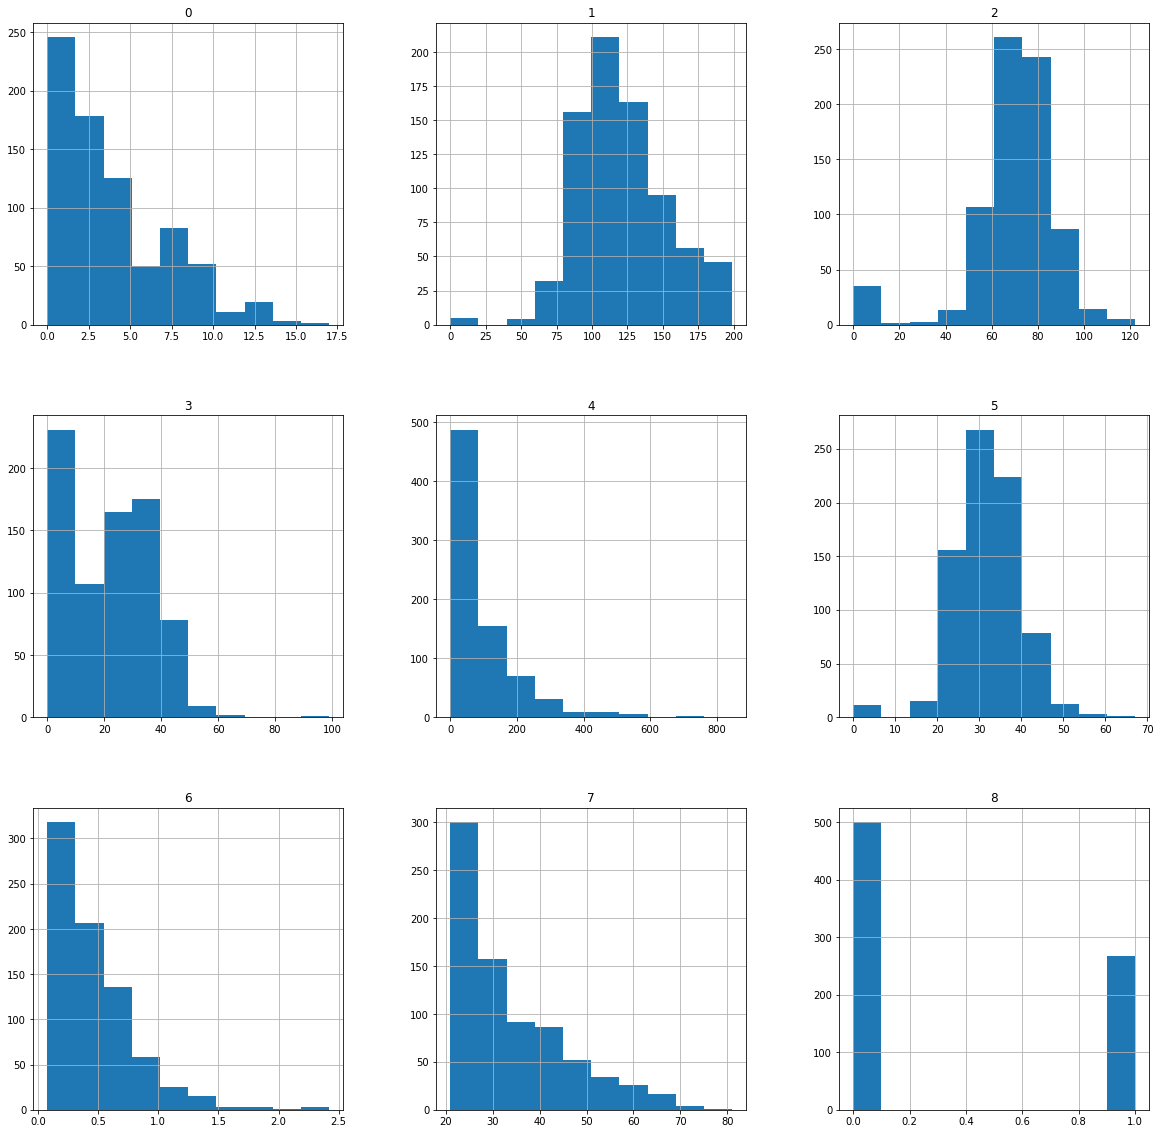

In [4]:
df.hist(figsize=(20,20))
plt.show()

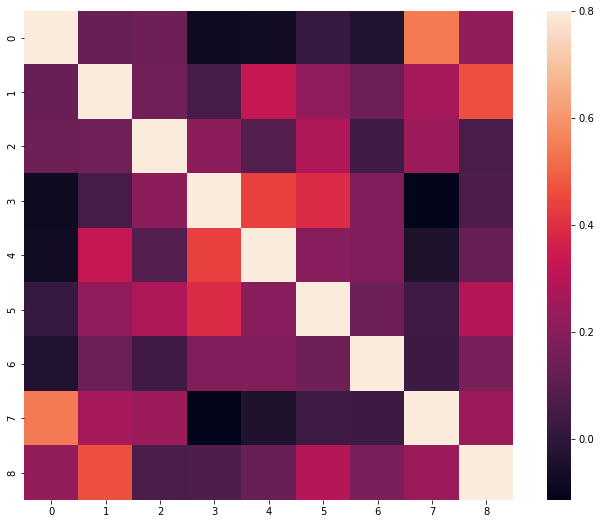

In [5]:
cormat = df.corr()
fig = plt.figure(figsize=(12,9))

sns.heatmap(cormat, vmax = 0.8, square=True)
plt.show()

## Data Modelling


The dataset is split into training and test set using stratified sampling, to preserve the class imbalance ratio in the both the train and test set. `sklearn` package is used for modeling. 

We use double resampling method for modeling:
* Entire data is split into Train and Test set (75:25 ratio)
* A 3 fold cross validation is performed on the Training set for parameter tuning


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


Majority class is labelled 0 in the dataset and minority class is labelled 1 - indicating a presence of diabetes in the patient. In all, for every diabetic patient, we have 1.865 non-diabetic patient. 

We use this ratio to inform the relative cost of false positive vs false negative. In practice, a more application specific cost has to be determined by experts that allows for realistic ratio of errors. 

The ratio is calculated below.

In [7]:
## Class ratios in training data
wts = {}
wts[0] = 1
wts[1] = len(np.where(y_train==0)[0])/len(np.where(y_train==1)[0])

print(f'Class weights are defined as :: {wts}')


Class weights are defined as :: {0: 1, 1: 1.8656716417910448}


Next, we define a function to calculate model error. This is defined as the percentage of samples that are correctly classified by the model. We use the predicted labels `yhat` and the actual data labesl `y` to measure the accuracy (or the error, which is `1-accuracy`)

In [8]:
#### Function to calculate standard classification error

def misclassification_error(yhat, y):
    return np.sum(yhat != y)/len(y)

### Cross validation

Previously separated train data is split again into 3 folds for identifying optimal model parameters. 

We use SVM classifier with RBF kernel becuase of its wide popularity. In particular we use, we use the libSVM package [3] in `sklearn`. The two relavant model parameter for RBF SVM are:
1. cost parameter `C`, that is used to penalize misclassifications. 
2. Gamma parameter `G`, that controls the flexibility of the decision boundary


For more details, please refer [2], [4]:


A grid search of the parameter is performed by measuring average validation errors across different folds. 


We build two models in the cross-validation loop below using the same data
1. `model_cs` - Cost sensitive model
2. `model_std` - Standard model 

In [9]:
C_val = [2 ** i for i in range(-30,15,3)]
G_val = [2 ** i for i in range(-30,15,3)]
K = 3
cv = KFold(n_splits=K, random_state=42, shuffle=False)

std_val_err_mat = np.zeros((len(C_val), len(G_val)))

cs_val_err_mat = np.zeros((len(C_val), len(G_val)))

k = 0
for learn_index, val_index in cv.split(X_train):
#     print(learn_index, val_index)
    X_learn, X_val, y_learn, y_val = X_train[learn_index], X_train[val_index], y_train[learn_index], y_train[val_index]
    k = k+1
    print(f'Cross-validation {k} out of {K}')
    for i in range(0,len(C_val)):
        for j in range(0,len(G_val)):
            c = C_val[i]
            g = G_val[j]
            print(f'\t ... Training model with C={c} and gamma = {g}')
            model_cs = svm.SVC(kernel='rbf', C=c, gamma=g, class_weight=wts)
            model_cs.fit(X_learn, y_learn)
            model_std = svm.SVC(kernel='rbf', C=c, gamma=g)
            model_std.fit(X_learn, y_learn)
            
            
            yhat_learn_std = model_std.predict(X_learn)
            yhat_val_std = model_std.predict(X_val)
            
            yhat_learn_cs = model_cs.predict(X_learn)
            yhat_val_cs = model_cs.predict(X_val)
            
            val_err_std = misclassification_error(yhat_val_std, y_val)
            val_err_cs = misclassification_error(yhat_val_cs, y_val)
            
            std_val_err_mat[i,j] = std_val_err_mat[i,j]+val_err_std
            
            cs_val_err_mat[i,j] = cs_val_err_mat[i,j]+val_err_cs
#             print(lrn_err_std, val_err_std, lrn_err_wt, val_err_wt)
            
            

Cross-validation 1 out of 3
	 ... Training model with C=9.313225746154785e-10 and gamma = 9.313225746154785e-10
	 ... Training model with C=9.313225746154785e-10 and gamma = 7.450580596923828e-09
	 ... Training model with C=9.313225746154785e-10 and gamma = 5.960464477539063e-08
	 ... Training model with C=9.313225746154785e-10 and gamma = 4.76837158203125e-07
	 ... Training model with C=9.313225746154785e-10 and gamma = 3.814697265625e-06
	 ... Training model with C=9.313225746154785e-10 and gamma = 3.0517578125e-05
	 ... Training model with C=9.313225746154785e-10 and gamma = 0.000244140625
	 ... Training model with C=9.313225746154785e-10 and gamma = 0.001953125
	 ... Training model with C=9.313225746154785e-10 and gamma = 0.015625
	 ... Training model with C=9.313225746154785e-10 and gamma = 0.125
	 ... Training model with C=9.313225746154785e-10 and gamma = 1
	 ... Training model with C=9.313225746154785e-10 and gamma = 8
	 ... Training model with C=9.313225746154785e-10 and gamma

	 ... Training model with C=0.001953125 and gamma = 8
	 ... Training model with C=0.001953125 and gamma = 64
	 ... Training model with C=0.001953125 and gamma = 512
	 ... Training model with C=0.001953125 and gamma = 4096
	 ... Training model with C=0.015625 and gamma = 9.313225746154785e-10
	 ... Training model with C=0.015625 and gamma = 7.450580596923828e-09
	 ... Training model with C=0.015625 and gamma = 5.960464477539063e-08
	 ... Training model with C=0.015625 and gamma = 4.76837158203125e-07
	 ... Training model with C=0.015625 and gamma = 3.814697265625e-06
	 ... Training model with C=0.015625 and gamma = 3.0517578125e-05
	 ... Training model with C=0.015625 and gamma = 0.000244140625
	 ... Training model with C=0.015625 and gamma = 0.001953125
	 ... Training model with C=0.015625 and gamma = 0.015625
	 ... Training model with C=0.015625 and gamma = 0.125
	 ... Training model with C=0.015625 and gamma = 1
	 ... Training model with C=0.015625 and gamma = 8
	 ... Training model 

	 ... Training model with C=7.450580596923828e-09 and gamma = 4096
	 ... Training model with C=5.960464477539063e-08 and gamma = 9.313225746154785e-10
	 ... Training model with C=5.960464477539063e-08 and gamma = 7.450580596923828e-09
	 ... Training model with C=5.960464477539063e-08 and gamma = 5.960464477539063e-08
	 ... Training model with C=5.960464477539063e-08 and gamma = 4.76837158203125e-07
	 ... Training model with C=5.960464477539063e-08 and gamma = 3.814697265625e-06
	 ... Training model with C=5.960464477539063e-08 and gamma = 3.0517578125e-05
	 ... Training model with C=5.960464477539063e-08 and gamma = 0.000244140625
	 ... Training model with C=5.960464477539063e-08 and gamma = 0.001953125
	 ... Training model with C=5.960464477539063e-08 and gamma = 0.015625
	 ... Training model with C=5.960464477539063e-08 and gamma = 0.125
	 ... Training model with C=5.960464477539063e-08 and gamma = 1
	 ... Training model with C=5.960464477539063e-08 and gamma = 8
	 ... Training model

	 ... Training model with C=1 and gamma = 0.015625
	 ... Training model with C=1 and gamma = 0.125
	 ... Training model with C=1 and gamma = 1
	 ... Training model with C=1 and gamma = 8
	 ... Training model with C=1 and gamma = 64
	 ... Training model with C=1 and gamma = 512
	 ... Training model with C=1 and gamma = 4096
	 ... Training model with C=8 and gamma = 9.313225746154785e-10
	 ... Training model with C=8 and gamma = 7.450580596923828e-09
	 ... Training model with C=8 and gamma = 5.960464477539063e-08
	 ... Training model with C=8 and gamma = 4.76837158203125e-07
	 ... Training model with C=8 and gamma = 3.814697265625e-06
	 ... Training model with C=8 and gamma = 3.0517578125e-05
	 ... Training model with C=8 and gamma = 0.000244140625
	 ... Training model with C=8 and gamma = 0.001953125
	 ... Training model with C=8 and gamma = 0.015625
	 ... Training model with C=8 and gamma = 0.125
	 ... Training model with C=8 and gamma = 1
	 ... Training model with C=8 and gamma = 8
	 

	 ... Training model with C=3.814697265625e-06 and gamma = 4.76837158203125e-07
	 ... Training model with C=3.814697265625e-06 and gamma = 3.814697265625e-06
	 ... Training model with C=3.814697265625e-06 and gamma = 3.0517578125e-05
	 ... Training model with C=3.814697265625e-06 and gamma = 0.000244140625
	 ... Training model with C=3.814697265625e-06 and gamma = 0.001953125
	 ... Training model with C=3.814697265625e-06 and gamma = 0.015625
	 ... Training model with C=3.814697265625e-06 and gamma = 0.125
	 ... Training model with C=3.814697265625e-06 and gamma = 1
	 ... Training model with C=3.814697265625e-06 and gamma = 8
	 ... Training model with C=3.814697265625e-06 and gamma = 64
	 ... Training model with C=3.814697265625e-06 and gamma = 512
	 ... Training model with C=3.814697265625e-06 and gamma = 4096
	 ... Training model with C=3.0517578125e-05 and gamma = 9.313225746154785e-10
	 ... Training model with C=3.0517578125e-05 and gamma = 7.450580596923828e-09
	 ... Training mode

	 ... Training model with C=512 and gamma = 4.76837158203125e-07
	 ... Training model with C=512 and gamma = 3.814697265625e-06
	 ... Training model with C=512 and gamma = 3.0517578125e-05
	 ... Training model with C=512 and gamma = 0.000244140625
	 ... Training model with C=512 and gamma = 0.001953125
	 ... Training model with C=512 and gamma = 0.015625
	 ... Training model with C=512 and gamma = 0.125
	 ... Training model with C=512 and gamma = 1
	 ... Training model with C=512 and gamma = 8
	 ... Training model with C=512 and gamma = 64
	 ... Training model with C=512 and gamma = 512
	 ... Training model with C=512 and gamma = 4096
	 ... Training model with C=4096 and gamma = 9.313225746154785e-10
	 ... Training model with C=4096 and gamma = 7.450580596923828e-09
	 ... Training model with C=4096 and gamma = 5.960464477539063e-08
	 ... Training model with C=4096 and gamma = 4.76837158203125e-07
	 ... Training model with C=4096 and gamma = 3.814697265625e-06
	 ... Training model with 

### Optimal model parameters

Optimal parameters are chosen based on a grid search for minimum average error values measued on the validation set across all k-folds. The matrices above `std_val_err_mat` and `cs_val_err_mat` hold the validation errors summed for all folds for the standard model and the cost-senstitive model respectively. 

These matrices have a size of (n,m) where n is the number of C parameter values and m is the number of gamma parameter values used for the grid search of optimal model parameters. Using these two matrices, optimal parameters are determined using the row and column indices corresponding to the lowest error value. Since we use 3 fold cross validation, we divide the matrices by 3 to obtain the average validation errors. Optimal parameters for the two models are printed below.

In [10]:
std_val_err_mat = std_val_err_mat/K
cs_val_err_mat = cs_val_err_mat/K


std_val_ind = np.where(std_val_err_mat == np.min(std_val_err_mat))
C_opt_std = C_val[std_val_ind[0][0]]
G_opt_std = G_val[std_val_ind[1][0]]
cs_val_ind = np.where(cs_val_err_mat == np.min(cs_val_err_mat))
C_opt_cs = C_val[cs_val_ind[0][0]]
G_opt_cs = G_val[cs_val_ind[1][0]]
print(f'Optimal C: {C_opt_std}, Optimal gamma: {G_opt_std}')
print(f'Optimal C: {C_opt_cs}, Optimal gamma: {G_opt_cs}')


Optimal C: 512, Optimal gamma: 3.0517578125e-05
Optimal C: 4096, Optimal gamma: 3.814697265625e-06


### Final model

Using the optimal parameters, we build final models using the entire train data. `fin_mod_cs` and `fin_mod_std` are the final cost-senstivie and the standard model respectively. 

Using these final models and the test data, model accuracies are determined below. 

In [11]:
## Build final model
print('Training standard model....')
fin_mod_std = svm.SVC(kernel='rbf', C=C_opt_std, gamma=G_opt_std)
fin_mod_std.fit(X_train, y_train)
print('Training cost-sensitive model')
fin_mod_cs = svm.SVC(kernel='rbf', C=C_opt_cs, gamma=G_opt_cs, class_weight=wts)
fin_mod_cs.fit(X_train, y_train)

print('Collecting accuracy metrics')
yhat_train_std = fin_mod_std.predict(X_train)
yhat_test_std = fin_mod_std.predict(X_test)

yhat_train_cs = fin_mod_cs.predict(X_train)
yhat_test_cs = fin_mod_cs.predict(X_test)

test_err_std = misclassification_error(yhat_test_std, y_test)
train_err_std = misclassification_error(yhat_train_std, y_train)


test_err_cs = misclassification_error(yhat_test_cs, y_test)
train_err_cs = misclassification_error(yhat_train_cs, y_train)





Training standard model....
Training cost-sensitive model


In [12]:
md(f"Standard classification accuracy of the model is {1-round(test_err_std,2)}. Whereas the weighted accuracy is {1-round(test_err_cs,2)}. ")


Standard classification accuracy of the model is 0.7. Whereas the weighted accuracy is 0.73. 

## Conclusion

We have shown that using cost-sensitive models for applications involving different costs attached to different types of errors is benefitial. It lets the experts incorporate more application specific information into the model. This process can also improve the final accuracy of the model. 

While better accuracy may not always be guaranteed, this process helps practioners in developing models that is more practical, since the model is built to minimize the costs that are closer to the actual process. 

## References

[1] A.Sivasankaran, V.Cherkassky, M. Albrech, E. Williams, M. Maiers, "Donor selection for hematopoietic stem cell transplant using cost-sensitive SVM", ICMLA, 2015

[2] V.Cherkassky, F.Mulier, "Predictive Learning", Wiley, 2012, NY USA

[3] LIBSVM -- A Library for Support Vector Machines, "https://www.csie.ntu.edu.tw/~cjlin/libsvm/" 

[4] V.Vapnik, "The Nature of Statistical Learning Theory", 2013

[5] Dataset, "https://www.kaggle.com/uciml/pima-indians-diabetes-database"